In [166]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import pprint


In [167]:
 #set the size of our plots as they are a little small by default.
plt.rcParams["figure.figsize"] = (20,5)

In [168]:
import os

#mac path
mac_file_path = r'/Users/nathanstuttard/Portfolio/Collision_trips_ML_Project/Predicting-car-insurance-cost-throughcollision-risk-through-machine-learning-/Data/LBD_New_York_collisions_and_weather_data.csv'

# Check if the file exists
if os.path.exists(mac_file_path):
    df = pd.read_csv(mac_file_path)  # Read the CSV into a DataFrame
    print(df.head())  # Display the first few rows of the DataFrame
else:
    print("File not found.")


   day  year  mo  da collision_date  temp  dewp     slp  visib  wdsp  mxpsd  \
0    2  2013   1   1     01/01/2013  37.8  23.6  1011.9   10.0   6.1    8.9   
1    3  2013   1   2     02/01/2013  27.1  10.5  1016.8   10.0   5.3    9.9   
2    4  2013   1   3     03/01/2013  28.4  14.1  1020.6   10.0   3.7    8.0   
3    5  2013   1   4     04/01/2013  33.4  18.6  1017.0   10.0   6.5   13.0   
4    6  2013   1   5     05/01/2013  36.1  18.7  1020.6   10.0   6.6   12.0   

   gust   max   min  prcp   sndp  fog  NUM_COLLISIONS  
0  19.0  39.9  33.1   0.0  999.9    0             381  
1  19.0  33.1  21.9   0.0  999.9    0             480  
2  15.0  32.0  24.1   0.0  999.9    0             549  
3  24.1  37.0  30.0   0.0  999.9    0             505  
4  21.0  42.1  32.0   0.0  999.9    0             389  


In [169]:
df = df.sort_values(["year", "mo", "da", "NUM_COLLISIONS"], ascending = (True, True, True, True)) # order the data by year, month, day in ascending order.
df.head() # check the data again by viewing the first 5 rows


,day,year,mo,da,collision_date,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,NUM_COLLISIONS
0,2,2013,1,1,01/01/2013,37.8,23.6,1011.9,10.0,6.1,8.9,19.0,39.9,33.1,0.0,999.9,0,381
1,3,2013,1,2,02/01/2013,27.1,10.5,1016.8,10.0,5.3,9.9,19.0,33.1,21.9,0.0,999.9,0,480
2,4,2013,1,3,03/01/2013,28.4,14.1,1020.6,10.0,3.7,8.0,15.0,32.0,24.1,0.0,999.9,0,549
3,5,2013,1,4,04/01/2013,33.4,18.6,1017.0,10.0,6.5,13.0,24.1,37.0,30.0,0.0,999.9,0,505
4,6,2013,1,5,05/01/2013,36.1,18.7,1020.6,10.0,6.6,12.0,21.0,42.1,32.0,0.0,999.9,0,389


day refers to the numerical day of the week; two in this case being Tuesday

da refers to the calendar day of the week"

In [170]:
total_collisions = df['NUM_COLLISIONS'].sum()
print(type(total_collisions))
print("Total collisions before cleaning:", total_collisions)


<class 'numpy.int64'>
Total collisions before cleaning: 1319249


Cleaning


In [171]:
#original df
original_df = df

# Trimming data to keep only days containing between 350 and 900 collisions
 
df_cleaned = df[(df["NUM_COLLISIONS"] > 350) & (df["NUM_COLLISIONS"] < 900)]

#Dropping nulls
df_cleaned = df_cleaned.dropna(how='all')


df_cleaned.dropna(subset=['NUM_COLLISIONS'], inplace=True) 
#df_cleaned['collision_date'] = pd.to_numeric(df['collision_date'], errors='coerce')  
total_collisions_post_clean = df_cleaned['NUM_COLLISIONS'].sum()
df_cleaned['collision_date'] = pd.to_datetime(df['collision_date'], errors='coerce')

print("Total collisions before cleaning:", total_collisions)
print("Total total_collisions_post_clean:", total_collisions_post_clean)
difference = total_collisions - total_collisions_post_clean
print(f"Dropped {difference} rows")


Total collisions before cleaning: 1319249
Total total_collisions_post_clean: 1307273
Dropped 11976 rows


In [172]:
df_cleaned.head()

,day,year,mo,da,collision_date,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,NUM_COLLISIONS
0,2,2013,1,1,2013-01-01,37.8,23.6,1011.9,10.0,6.1,8.9,19.0,39.9,33.1,0.0,999.9,0,381
1,3,2013,1,2,2013-02-01,27.1,10.5,1016.8,10.0,5.3,9.9,19.0,33.1,21.9,0.0,999.9,0,480
2,4,2013,1,3,2013-03-01,28.4,14.1,1020.6,10.0,3.7,8.0,15.0,32.0,24.1,0.0,999.9,0,549
3,5,2013,1,4,2013-04-01,33.4,18.6,1017.0,10.0,6.5,13.0,24.1,37.0,30.0,0.0,999.9,0,505
4,6,2013,1,5,2013-05-01,36.1,18.7,1020.6,10.0,6.6,12.0,21.0,42.1,32.0,0.0,999.9,0,389


Descriptive statistics

In [173]:
def collision_grouping_decorator(group_by):
    """Decorator to group collisions by day or month."""
    def wrapper(func):
        def inner(dataframe):
            collisions = dataframe.groupby(group_by)['NUM_COLLISIONS'].sum().reset_index()
            collisions.columns = ['Group', 'Total Collisions']
            return collisions.sort_values(by='Total Collisions', ascending=False)
        return inner
    return wrapper

@collision_grouping_decorator('day')
def group_collisions_by_day(dataframe):
    """Groups collisions by day of the week."""
    pass  # The actual logic is handled by the decorator

@collision_grouping_decorator('mo')
def group_collisions_by_month(dataframe):
    """Groups collisions by month."""
    pass  # The actual logic is handled by the decorator

# Get collisions grouped by day and month
collisions_per_day_df = group_collisions_by_day(df_cleaned)
collisions_per_month_df = group_collisions_by_month(df_cleaned)

# Print results
print("Collisions per Day of the week:")
print(collisions_per_day_df)

print("\nCollisions per Month:")
print(collisions_per_month_df)


##Interesting - Friday as the most collisions, with Sunday the least - rush hour, commuting
## so what's the connection between Friday and Sunday. Sunday is a quieter day, Friday busier. Don't have a time of day so can't look at this in more detail.
##is there time data available?


#Correlation between weather? Rainfall on a particular day? or by month?

Collisions per Day of the week:
   Group  Total Collisions
4      5            207693
3      4            196751
1      2            194514
2      3            194134
0      1            187203
5      6            175254
6      7            151724

Collisions per Month:
    Group  Total Collisions
5       6            118319
9      10            116505
4       5            116190
6       7            113076
8       9            111650
7       8            111309
10     11            109884
11     12            108360
2       3            106432
3       4            104204
0       1             99241
1       2             92103


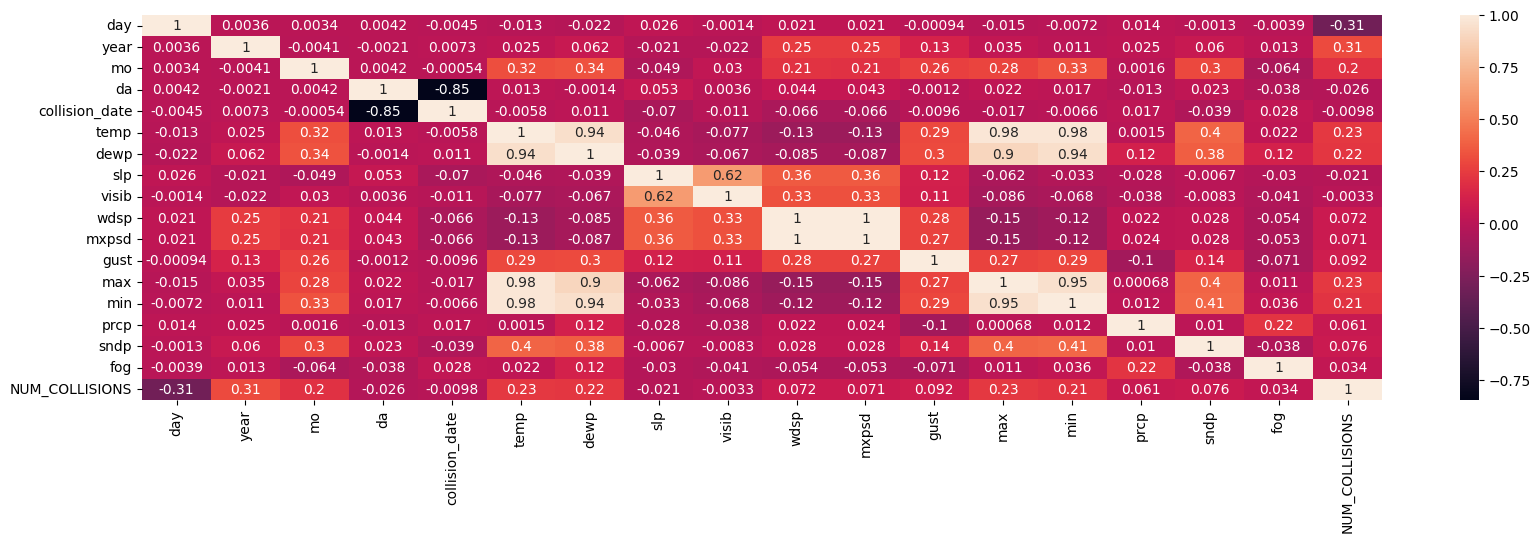

In [174]:
## does correlation work before the mapping?

corrMatrix = df_cleaned.corr()
# Creates correlation matrix which shows all the correlations we have
sn.heatmap(corrMatrix, annot=True)
#Makes a heatmap of the matrix
plt.show()

In [175]:
day_mapped_df = df_cleaned.copy()

# Define a mapping for days of the week
day_mapping = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 
               5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

# Apply the day mapping to the 'day' column
day_mapped_df.loc[:, 'day_mapped'] = day_mapped_df['day'].map(day_mapping)

# Group by year and day of the week, then sum the number of collisions
collisions_per_day_per_year = day_mapped_df.groupby(['year', 'day_mapped'])['NUM_COLLISIONS'].sum().reset_index()

# Pivot the table to have years as rows and days of the week as columns
collisions_per_day_per_year_pivot = collisions_per_day_per_year.pivot_table(
    index='year', columns='day_mapped', values='NUM_COLLISIONS', fill_value=0
)

# Calculate total collisions per day across all years
total_collisions_per_day = collisions_per_day_per_year.groupby('day_mapped')['NUM_COLLISIONS'].sum()

# Sort days based on total collisions (descending order)
sorted_days = total_collisions_per_day.sort_values(ascending=False).index

# Reorder columns in the pivot table
collisions_per_day_per_year_pivot = collisions_per_day_per_year_pivot[sorted_days]

# Display the resulting table
print(collisions_per_day_per_year_pivot)

day_mapped   Friday  Thursday  Tuesday  Wednesday   Monday  Saturday   Sunday
year                                                                         
2013        33109.0   29726.0  30214.0    29138.0  29453.0   27702.0  24135.0
2014        32415.0   30473.0  29628.0    30586.0  29003.0   27658.0  22833.0
2015        33146.0   32906.0  32496.0    32403.0  31059.0   27978.0  24644.0
2016        37147.0   34682.0  34314.0    34235.0  32000.0   30794.0  26059.0
2017        34948.0   34445.0  33721.0    33856.0  32716.0   30640.0  27464.0
2018        36928.0   34519.0  34141.0    33916.0  32972.0   30482.0  26589.0


Correlations

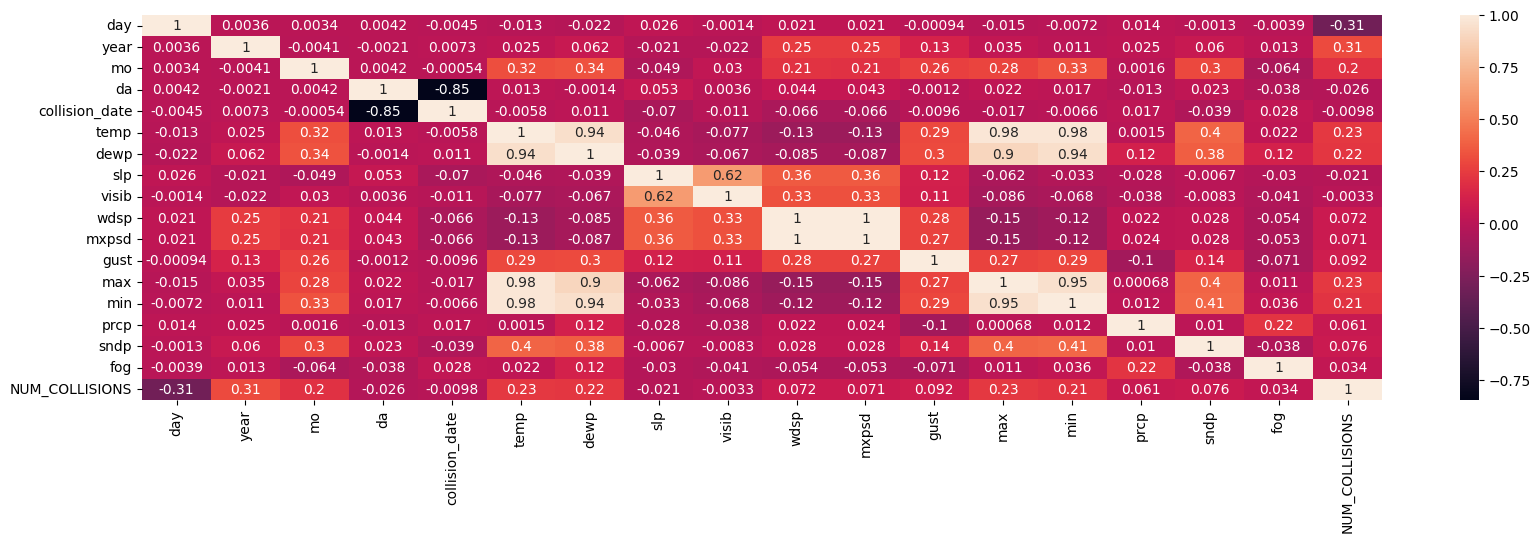

In [176]:
corrMatrix = df_cleaned.corr()
# Creates correlation matrix which shows all the correlations we have
sn.heatmap(corrMatrix, annot=True)
#Makes a heatmap of the matrix
plt.show()

Insights:
Num_Coll correlates positively with temp, dewp, max and min temp
Also interesting that mo correlates with the above

The -0.31 correlation between NUM_COLLISIONS and day suggests that as day increases, NUM_COLLISIONS tends to decrease on average—but this does not mean a strict linear decrease. 
Actual data (showing Friday as the worst day) suggests a non-linear trend, where collisions peak midweek and drop significantly on weekends.

Regression Analysis

In [177]:
df_2012 = df_cleaned[df_cleaned["year"] == 2012]
df_2012.loc[df_2012['day'] > 0, 'day'] = df_2012['day']+1 # change all days by adding 1.

df_2012.loc[df_2012['day'] == 8, 'day'] = 1 # change days that equal 8 to day 1

In [178]:
# Filter data for the year 2013
df_2013 = df_cleaned[df_cleaned["year"] == 2013].copy()

# Increment all days by 1
df_2013.loc[df_2013['day'] > 0, 'day'] += 1

# Change days that are equal to 8 to 1
df_2013.loc[df_2013['day'] == 8, 'day'] = 1

# Filter data for the year 2014
df_2014 = df_cleaned[df_cleaned["year"] == 2014].copy()

# Increment all days by 1
df_2014.loc[df_2014['day'] > 0, 'day'] += 1

# Change days that are equal to 8 to 1
df_2014.loc[df_2014['day'] == 8, 'day'] = 1

# Filter data for the year 2015
df_2015 = df_cleaned[df_cleaned["year"] == 2015].copy()

# Increment all days by 1
df_2015.loc[df_2015['day'] > 0, 'day'] += 1

# Change days that are equal to 8 to 1
df_2015.loc[df_2015['day'] == 8, 'day'] = 1

# Filter data for the year 2016
df_2016 = df_cleaned[df_cleaned["year"] == 2016].copy()

# Increment all days by 1
df_2016.loc[df_2016['day'] > 0, 'day'] += 1

# Change days that are equal to 8 to 1
df_2016.loc[df_2016['day'] == 8, 'day'] = 1

all_years = [df_2013, df_2014, df_2015, df_2016]
df_final = pd.concat(all_years)
print(df_final["day"].count())

df_final.head()


1446


,day,year,mo,da,collision_date,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,NUM_COLLISIONS
0,3,2013,1,1,2013-01-01,37.8,23.6,1011.9,10.0,6.1,8.9,19.0,39.9,33.1,0.0,999.9,0,381
1,4,2013,1,2,2013-02-01,27.1,10.5,1016.8,10.0,5.3,9.9,19.0,33.1,21.9,0.0,999.9,0,480
2,5,2013,1,3,2013-03-01,28.4,14.1,1020.6,10.0,3.7,8.0,15.0,32.0,24.1,0.0,999.9,0,549
3,6,2013,1,4,2013-04-01,33.4,18.6,1017.0,10.0,6.5,13.0,24.1,37.0,30.0,0.0,999.9,0,505
4,7,2013,1,5,2013-05-01,36.1,18.7,1020.6,10.0,6.6,12.0,21.0,42.1,32.0,0.0,999.9,0,389


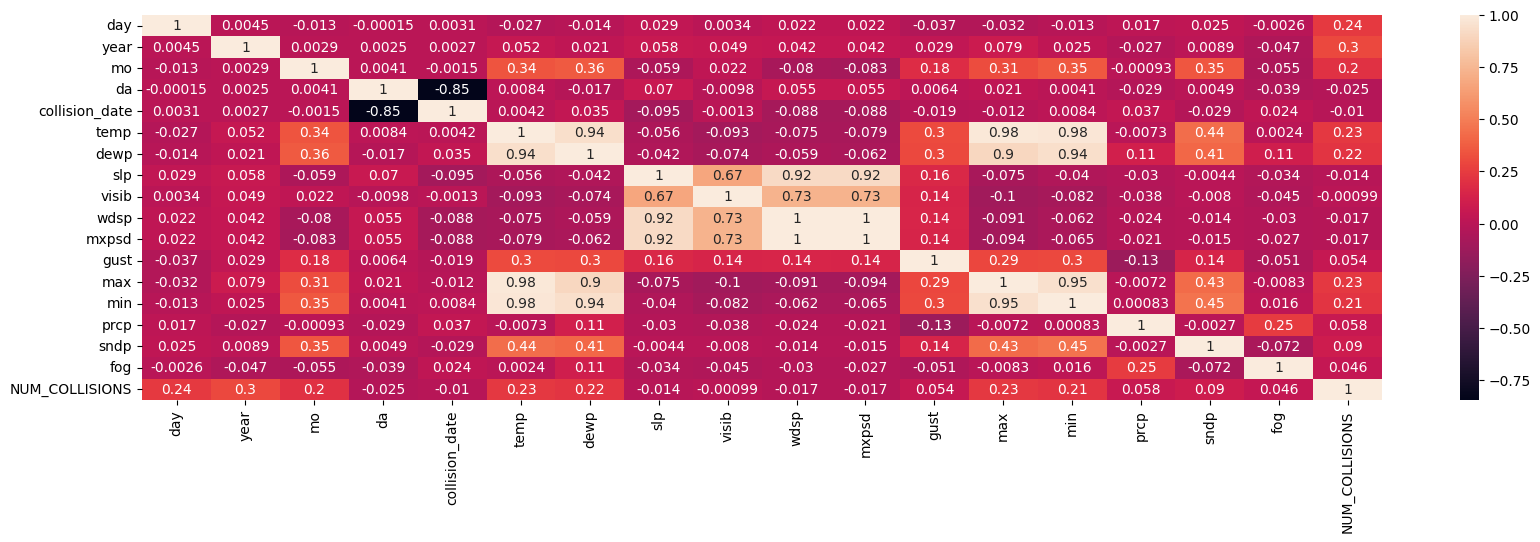

In [179]:
corrMatrix = df_final.corr()
# Creates correlation matrix which shows all the correlations we have
sn.heatmap(corrMatrix, annot=True)
#Makes a heatmap of the matrix
plt.show()

Correlation is now a weak, but positive one, suggesting collisions increase as the week goes on

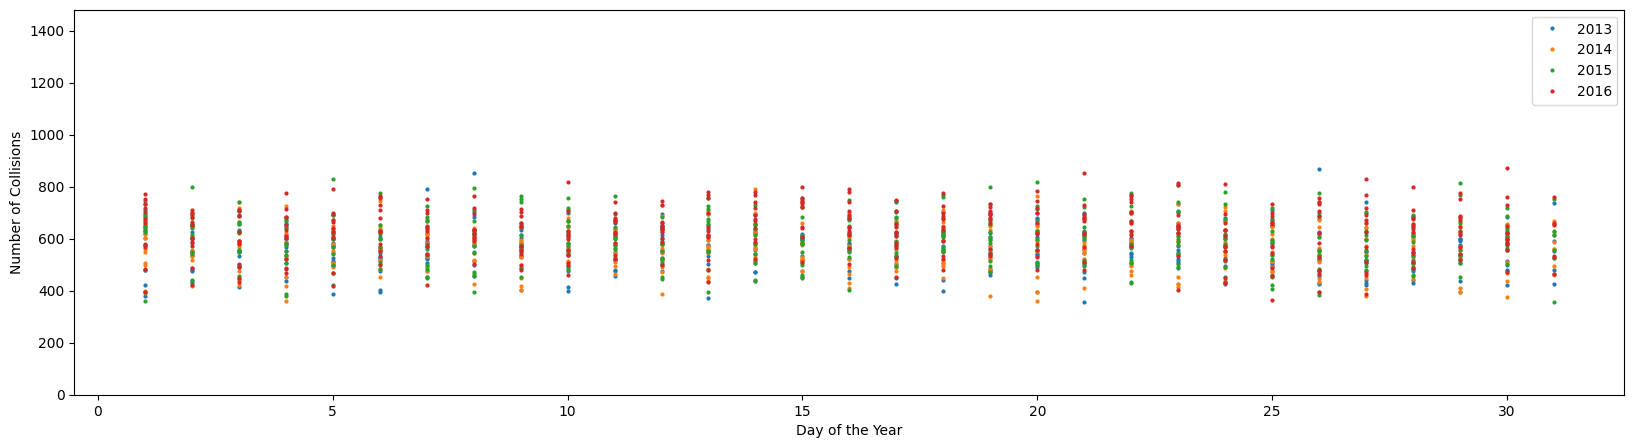

In [180]:
# check out this plot
groups = df_final.groupby('year') # We group by year as we want to create a legend and make the visualization clearer using color.
plt.ylim(0, 1480)

for name, group in groups:
    plt.plot(group.da, group.NUM_COLLISIONS, marker='o', linestyle='', markersize=2, label=name)

plt.legend()

# Adding axis titles
plt.xlabel('Day of the Year')
plt.ylabel('Number of Collisions')

plt.show()

Regression model

In [181]:
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from keras import layers
from tensorflow.python.keras.layers import Dense
print(tf.__version__)

2.17.0


#very simple model, with just one single input (days) and one output (NUM_COLLISIONS).

Let's call this the Day Model

In [182]:
one_input_data = [df_final["day"], df_final["NUM_COLLISIONS"]] # create an array of all values for day and all values for NUM_TRIPS in two columns
headers = ["day", "NUM_COLLISIONS"] # declare the titles of our input and output. As you can see day is first and NUM_TRIPS is second and they correspond to the line above
df_one_input = pd.concat(one_input_data, axis=1, keys=headers) # Bring these two arrays together to make a new dataframe
df_one_input.head(20)

,day,NUM_COLLISIONS
0,3,381
1,4,480
2,5,549
3,6,505
4,7,389
5,1,393
6,2,521
7,3,513
8,4,487
9,5,555


In [183]:
 #ok now to train model
 #This code is performing a common task in data science: splitting a dataset into training and test sets. 

train_dataset = df_one_input.sample(frac=0.8, random_state=0)

test_dataset = df_one_input.drop(train_dataset.index)

In [184]:
train_dataset.describe()
test_dataset.describe()

,day,NUM_COLLISIONS
count,289.000000,289.000000
mean,4.114187,591.498270
std,1.992374,93.822384
min,1.000000,357.000000
25%,2.000000,526.000000
50%,4.000000,590.000000
75%,6.000000,653.000000
max,7.000000,867.000000


In [185]:
#train_features = train_dataset.copy(): Creates a copy of the train_dataset DataFrame and stores it in train_features.
#test_features = test_dataset.copy(): Similarly, creates a copy of the test_dataset DataFrame and stores it in test_features.

train_features = train_dataset.copy()
test_features = test_dataset.copy()

#The labels (train_labels and test_labels) represent the actual number of collisions in each row of your dataset. 
# The model will use other features (input variables) to try and predict this value. 

train_labels = train_features.pop('NUM_COLLISIONS')
test_labels = test_features.pop('NUM_COLLISIONS')



In [186]:
scale_factor = 1000000

train_labels = train_labels/scale_factor
test_labels = test_labels/scale_factor
pprint.pprint(train_labels)

##train_labels = train_labels / scale_factor: This line divides each element in the train_labels Series by the scale_factor (which is set to 1,000,000). 
# This effectively scales down the values of the labels in the training dataset, making them smaller and potentially easier to work with.

#test_labels = test_labels / scale_factor: 
# Similarly, this line divides each element in the test_labels Series by the same scale_factor, scaling down the labels in the testing dataset.

1096    0.000422
482     0.000597
184     0.000438
302     0.000558
995     0.000501
          ...   
460     0.000484
589     0.000572
147     0.000686
160     0.000624
1124    0.000596
Name: NUM_COLLISIONS, Length: 1157, dtype: float64


In [187]:
import tensorflow as tf
import numpy as np

# Assuming train_features is your training data

#tf.keras.layers.Normalization: This creates a normalization layer that will standardize the features (input data).
#axis=-1: This indicates that normalization will be applied across the last axis. 
# For example, if you have a 2D array (matrix), normalization will be applied to each row independently.

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

first = np.array(train_features[:1])

# Print the first example before and after normalization
with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())


First example: [[7]]

Normalized: [[1.51]]


In [188]:
import tensorflow as tf
import numpy as np

# Assuming train_features is your DataFrame and 'day' is one of its columns
day = np.array(train_features['day'])

# train_features['day']: This selects the column labeled 'day' from the train_features DataFrame. 
# It assumes that train_features is a pandas DataFrame containing various features.

# tf.keras.layers.Normalization: This creates a normalization layer specifically for the day feature.
#input_shape=[1,]: This indicates that the input to the layer will be a 1D array with one element (the day value).
#axis=None: This means that normalization will be applied to the entire input (single value), rather than along a specific axis.

# Define and adapt the Normalization layer
day_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
day_normalizer.adapt(day)


/Users/nathanstuttard/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [189]:
import tensorflow as tf
import numpy as np

# This creates a sequential model, which is a linear stack of layers. 
# You can think of it as a chain where the output of one layer is the input to the next.

# Assuming day_normalizer is already defined as in your previous code
# Define the model
day_model = tf.keras.Sequential([
    day_normalizer,
    tf.keras.layers.Dense(units=1)  # accessing Dense layer through tf.keras.layers
])

# : This adds a Dense layer with a single unit (or neuron). 
# A Dense layer is a fully connected layer where each input node is connected to each output node. 
# The output will be a single value, which might represent a prediction (for example, predicting a target variable based on the normalized day).

# Print model summary
day_model.summary()



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_11                │ (None, 1)              │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [190]:
day_model.predict(day[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[ 0.5799995 ],
       [-0.38499823],
       [ 0.1940004 ],
       [ 0.00100087],
       [ 0.00100087],
       [ 0.00100087],
       [-0.19199868],
       [ 0.38699993],
       [-0.19199868],
       [ 0.5799995 ]], dtype=float32)

In [191]:
day_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

print("It worked")

It worked


Keras model - exec training for 100 epochs

In [192]:
%%time
history = day_model.fit(
    train_features['day'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 2.81 s, sys: 561 ms, total: 3.37 s
Wall time: 2.42 s


In [193]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.017085,0.005494,95
96,0.010500,0.009182,96
97,0.007096,0.004458,97
98,0.009297,0.014994,98
99,0.012257,0.003695,99


In [194]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [NUM_Collisions]')
  plt.legend()
  plt.grid(True)
  
  
  

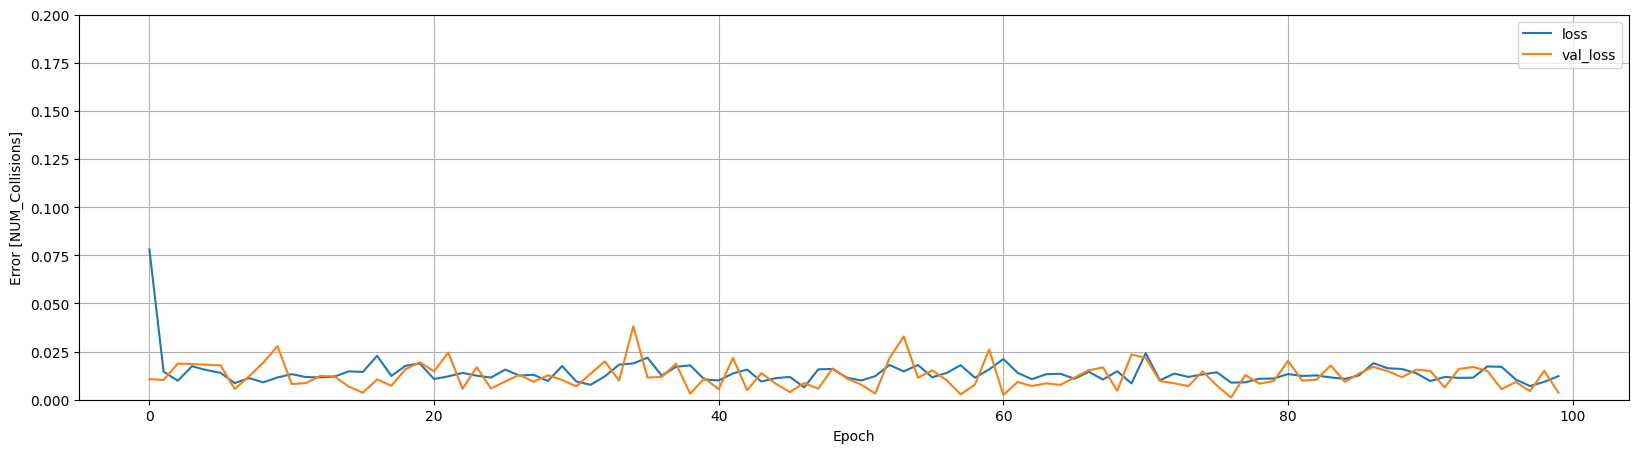

In [195]:
plot_loss(history)

# this plot indicates that the model is training well.



Why is it training well? 

loss (training loss) Measures the error on the training data during each iteration of model training.	

val loss - Reflects the error on a separate validation dataset that the model has not seen during training.

In [196]:
test_results = {}

test_results['day_model'] = day_model.evaluate(
    test_features['day'],
    test_labels, verbose=0)

In [197]:
x = tf.linspace(1, 7, 8)
y = day_model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [198]:
#sense check
print("Unique days:", train_features['day'].unique())
print("Number of collisions:", train_labels.shape)


Unique days: [7 2 5 4 3 6 1]
Number of collisions: (1157,)


In [199]:
print("Predicted days:", x[:10])
print("Predicted NUM_Collisions:", y[:10])


Predicted days: tf.Tensor(
[1.         1.85714286 2.71428571 3.57142857 4.42857143 5.28571429
 6.14285714 7.        ], shape=(8,), dtype=float64)
Predicted NUM_Collisions: [[ 0.00817708]
 [ 0.0065709 ]
 [ 0.00496472]
 [ 0.00335854]
 [ 0.00175236]
 [ 0.00014618]
 [-0.00146   ]
 [-0.00306618]]


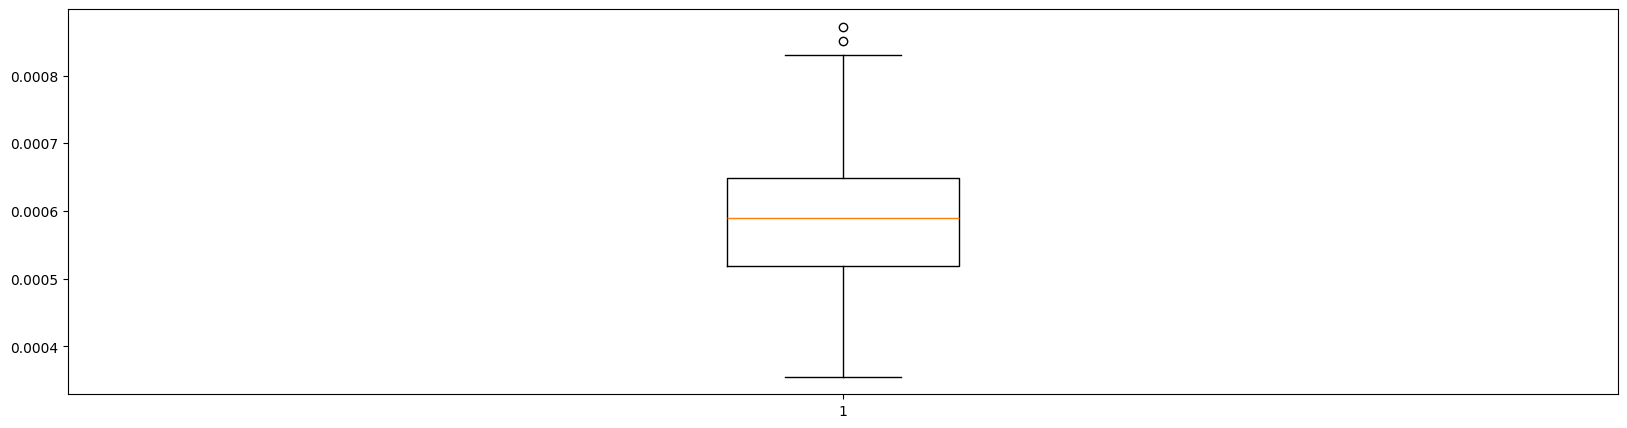

In [200]:
plt.boxplot(train_labels)  # Boxplot to check for outliers
plt.show()


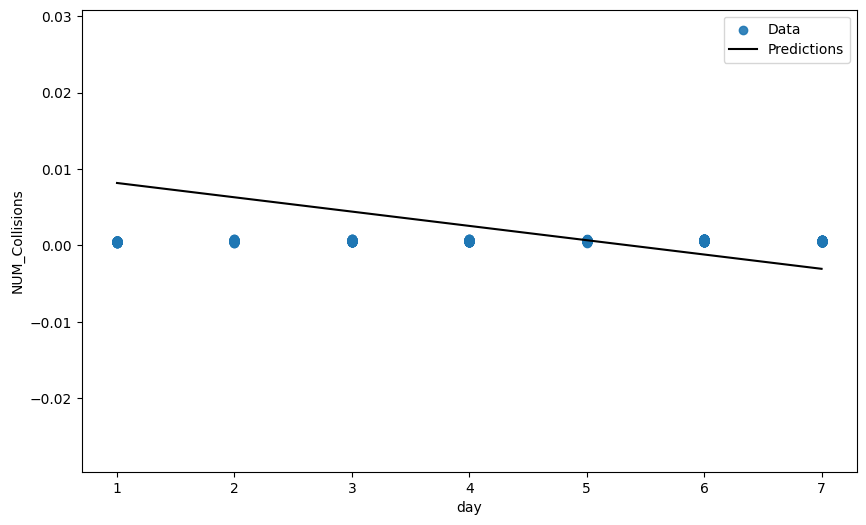

y min: -0.003066184 y max: 0.008177077
train_labels min: 0.000355 train_labels max: 0.000872
x shape: 8
y shape: 8


In [201]:
import matplotlib.pyplot as plt

def plot_day(x, y, train_features, train_labels):
    plt.figure(figsize=(10, 6))  # Set a more standard figure size
    plt.scatter(train_features['day'], train_labels, label='Data', alpha=0.9)
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('day')
    plt.ylabel('NUM_Collisions')
    plt.ylim([train_labels.min() - 0.03, train_labels.max() + 0.03])
    
    #plt.ylim([-0.05, 0.05])  # Adjust y-axis limits as needed
    plt.legend()
    plt.show()

plot_day(x, y, train_features, train_labels)

print("y min:", y.min(), "y max:", y.max())
print("train_labels min:", train_labels.min(), "train_labels max:", train_labels.max())

print("x shape:", len(x))
print("y shape:", len(y))

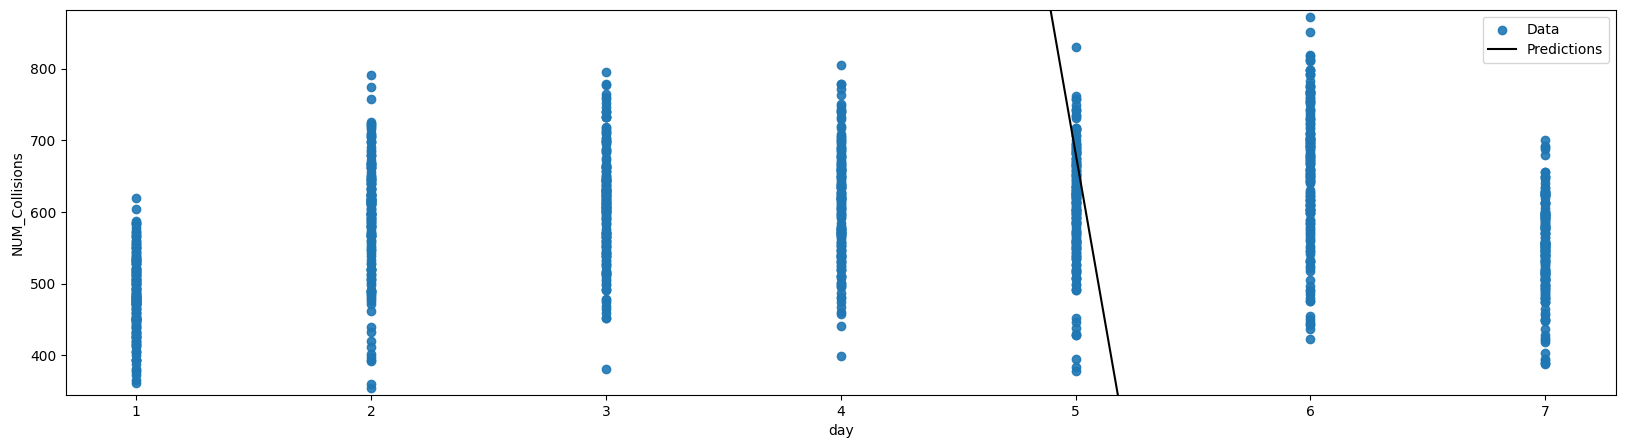

In [202]:
scaled_train_labels = train_labels * scale_factor
scaled_y = y * scale_factor  # Ensure predictions are also scaled back

plt.scatter(train_features['day'], scaled_train_labels, label='Data', alpha=0.9)
plt.plot(x, scaled_y, color='k', label='Predictions')
plt.xlabel('day')
plt.ylabel('NUM_Collisions')
plt.ylim([scaled_train_labels.min() - 10, scaled_train_labels.max() + 10])
plt.legend()
plt.show()

So have a boxplot of the raw data and then the predicted data

Linear regression model 

Our inputs will now be 'day', 'temperature' to predict

In [203]:
many_input_data = [df_final["day"], df_final["temp"], df_final["NUM_COLLISIONS"]] # create an array of all values for day and all values for NUM_TRIPS in two columns
headers = ["day", "temp", "NUM_COLLISIONS"] # declare the titles of our input and output. As you can see day is first and NUM_TRIPS is second and these correspond to the line above
df_many_input = pd.concat(many_input_data, axis=1, keys=headers) # Bring these two arrays together to make a new dataframe
df_many_input.head()

,day,temp,NUM_COLLISIONS
0,3,37.8,381
1,4,27.1,480
2,5,28.4,549
3,6,33.4,505
4,7,36.1,389


In [204]:
train_dataset = df_many_input.sample(frac=0.8, random_state=0)
test_dataset = df_many_input.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('NUM_COLLISIONS')
test_labels = test_features.pop('NUM_COLLISIONS')

In [205]:
train_features.head()

,day,temp
1096,7,35.8
482,2,54.5
184,5,79.5
302,4,52.8
995,4,68.4


In [206]:
train_labels = train_labels/scale_factor
test_labels = test_labels/scale_factor

In [207]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())
  
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

First example: [[ 7.  35.8]]

Normalized: [[ 1.51 -1.15]]


In [208]:
linear_model.predict(train_features[:10])

linear_model.layers[1].kernel

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [209]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 2.85 s, sys: 562 ms, total: 3.41 s
Wall time: 2.42 s


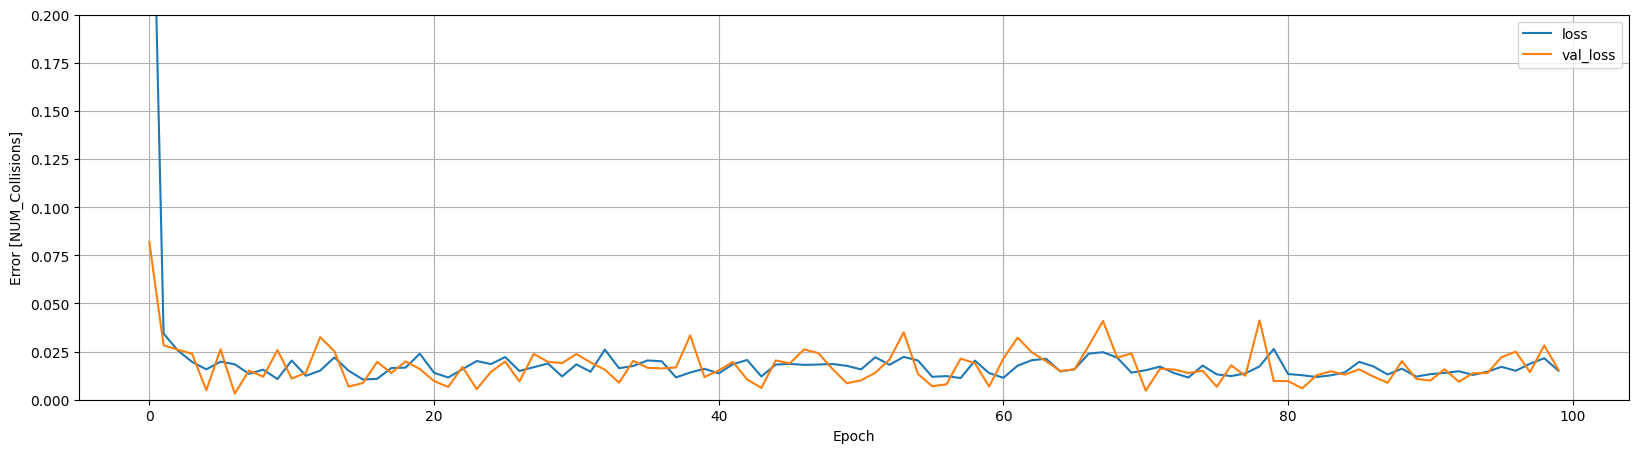

In [210]:
plot_loss(history)

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [211]:
pd.DataFrame(test_results, index=['Mean absolute error [NUM_COLLISIONS]'])

# Mean Absolute Error (MAE) is a measure of the average size of the mistakes in a collection of predictions, without taking their direction into account

,day_model,linear_model
Mean absolute error [NUM_COLLISIONS],0.003454,0.016041


So the linear model, consisting of day of the week (Monday - Friday) has a lower MSE which means it is better at predicting the total collisions than the linear model which has temp, day to predict number of collisions

Deep Neural Network

In [212]:
# Check dataframe
df_final.head(500)



,day,year,mo,da,collision_date,temp,dewp,slp,visib,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,NUM_COLLISIONS
0,3,2013,1,1,2013-01-01,37.8,23.6,1011.9,10.0,6.1,8.9,19.0,39.9,33.1,0.00,999.9,0,381
1,4,2013,1,2,2013-02-01,27.1,10.5,1016.8,10.0,5.3,9.9,19.0,33.1,21.9,0.00,999.9,0,480
2,5,2013,1,3,2013-03-01,28.4,14.1,1020.6,10.0,3.7,8.0,15.0,32.0,24.1,0.00,999.9,0,549
3,6,2013,1,4,2013-04-01,33.4,18.6,1017.0,10.0,6.5,13.0,24.1,37.0,30.0,0.00,999.9,0,505
4,7,2013,1,5,2013-05-01,36.1,18.7,1020.6,10.0,6.6,12.0,21.0,42.1,32.0,0.00,999.9,0,389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,6,2014,5,16,NaT,65.9,62.8,1015.2,5.4,5.6,8.9,24.1,71.1,57.9,0.07,999.9,0,700
501,7,2014,5,17,NaT,61.6,48.2,1014.5,8.7,5.3,8.0,18.1,70.0,53.1,1.51,999.9,0,619
502,1,2014,5,18,NaT,60.0,36.4,1020.5,10.0,4.3,8.9,15.9,70.0,51.1,0.00,999.9,0,507
503,2,2014,5,19,NaT,60.3,32.4,1020.9,10.0,4.3,11.1,15.9,72.0,48.9,0.00,999.9,0,572


In [213]:
# One-Hot Encoding for day
df_final['da'] = df_final['da'].map({ 1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'})
df_final = pd.get_dummies(df_final, columns=['da'], prefix='', prefix_sep='')

# One-Hot Encoding for month
df_final['mo'] = df_final['mo'].map({ 1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})
df_final = pd.get_dummies(df_final, columns=['mo'], prefix='', prefix_sep='')


In [214]:
dnn_many_input_data = [df_final["year"], df_final["temp"], df_final["dewp"], df_final["slp"], df_final["visib"], df_final["wdsp"], df_final["gust"], df_final["prcp"], df_final["sndp"], df_final["fog"], df_final["Sunday"], df_final["Monday"], df_final["Tuesday"], df_final["Wednesday"], df_final["Thursday"], df_final["Friday"], df_final["Saturday"], df_final["January"], df_final["February"], df_final["March"], df_final["April"], df_final["May"], df_final["June"], df_final["July"], df_final["August"], df_final["September"], df_final["October"], df_final["November"], df_final["December"], df_final["NUM_COLLISIONS"]]
headers = ["year","temp","dewp","slp","visib","wdsp","gust","prcp","sndp","fog","Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","January","February","March","April","May","June","July","August","September","October","November","December","NUM_COLLISIONS"]
df_dnn_many_input = pd.concat(dnn_many_input_data, axis=1, keys=headers)
df_dnn_many_input.head()

,year,temp,dewp,slp,visib,wdsp,gust,prcp,sndp,fog,...,April,May,June,July,August,September,October,November,December,NUM_COLLISIONS
0,2013,37.8,23.6,1011.9,10.0,6.1,19.0,0.0,999.9,0,...,False,False,False,False,False,False,False,False,False,381
1,2013,27.1,10.5,1016.8,10.0,5.3,19.0,0.0,999.9,0,...,False,False,False,False,False,False,False,False,False,480
2,2013,28.4,14.1,1020.6,10.0,3.7,15.0,0.0,999.9,0,...,False,False,False,False,False,False,False,False,False,549
3,2013,33.4,18.6,1017.0,10.0,6.5,24.1,0.0,999.9,0,...,False,False,False,False,False,False,False,False,False,505
4,2013,36.1,18.7,1020.6,10.0,6.6,21.0,0.0,999.9,0,...,False,False,False,False,False,False,False,False,False,389


In [215]:
train_dataset = df_dnn_many_input.sample(frac=0.8, random_state=0)
test_dataset = df_dnn_many_input.drop(train_dataset.index)
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('NUM_COLLISIONS')
test_labels = test_features.pop('NUM_COLLISIONS')

#Hit error here

In [216]:
# Scale labels

train_labels = train_labels/scale_factor
test_labels = test_labels/scale_factor

In [217]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [218]:
#normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

ValueError: The layer was built with input_shape=(1157, 2), but adapt() is being called with data with an incompatible shape, data.shape=(1157, 29)